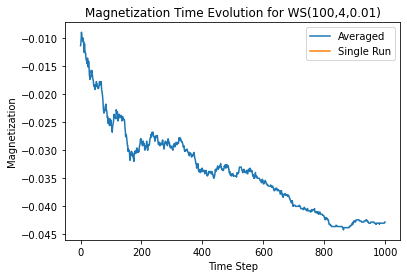

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def initialize_opinions(N):
    return np.random.choice([-1, 1], size=N)

def select_neighbors(graph, node, q):
    neighbors = list(graph.neighbors(node))
    if len(neighbors) >= q:
        return np.random.choice(neighbors, size=q, replace=False)
    else:
        return np.random.choice(neighbors, size=q, replace=True)

def update_opinion(opinions, graph, p, epsilon, q):
    node = np.random.randint(len(opinions))
    if np.random.random() < p:  # Independence
        opinions[node] *= -1
    else:  # Conformity
        neighbors = select_neighbors(graph, node, q)
        if len(np.unique(opinions[neighbors])) == 1:  # Unanimous q-panel
            opinions[node] = opinions[neighbors[0]]
        elif np.random.random() < epsilon:
            opinions[node] *= -1
    return opinions

def simulate_q_voter(N, q, p, epsilon, graph, num_steps, num_runs):
    magnetization_history = np.zeros((num_runs, num_steps))
    for run in range(num_runs):
        opinions = initialize_opinions(N)
        for step in range(num_steps):
            magnetization = np.mean(opinions)
            magnetization_history[run, step] = magnetization
            opinions = update_opinion(opinions, graph, p, epsilon, q)
    return magnetization_history

# Network Creation
N = 100
q_values = [3, 4]
p_values = np.arange(0.0, 0.52, 0.02)
num_steps = 1000
num_runs = 100

networks = {
    "Complete Graph": nx.complete_graph(N),
    "BA(100,4)": nx.barabasi_albert_graph(N, 4),
    "WS(100,4,0.01)": nx.watts_strogatz_graph(N, 4, 0.01),
    "WS(100,4,0.2)": nx.watts_strogatz_graph(N, 4, 0.2)
}

# Simulate and calculate magnetization
magnetization_results = {}

for q in q_values:
    magnetization_results[q] = {}
    for p in p_values:
        magnetization_results[q][p] = {}
        for network_name, graph in networks.items():
            magnetization_history = simulate_q_voter(N, q, p, 0.0, graph, num_steps, num_runs)
            avg_magnetization = np.mean(magnetization_history, axis=0)
            magnetization_results[q][p][network_name] = avg_magnetization

# Plot the time evolution of magnetization for WS(100,4,0.01) network
network_name = "WS(100,4,0.01)"
avg_magnetization = magnetization_results[q_values[0]][p_values[0]][network_name]
single_run_magnetization = magnetization_results[q_values[0]][p_values[0]][network_name][0]

plt.plot(avg_magnetization, label="Averaged")
plt.plot(single_run_magnetization, label="Single Run")
plt.xlabel("Time Step")
plt.ylabel("Magnetization")
plt.title(f"Magnetization Time Evolution for {network_name}")
plt.legend()
plt.show()


p = 0.5: 100%|██████████| 1000/1000 [00:02<00:00, 333.88it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:02<00:00, 365.62it/s]


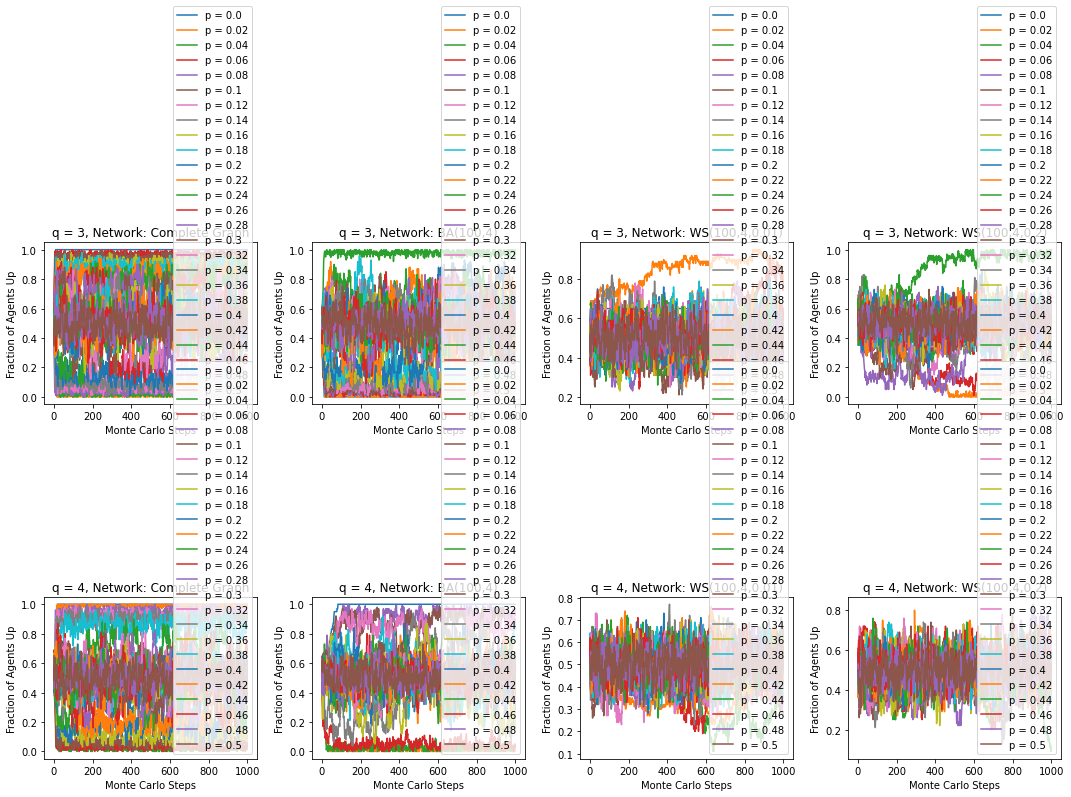

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

def q_voter_model(N, q, p, network):
    spins = np.random.choice([-1, 1], size=N)
    adjacency_matrix = nx.to_numpy_array(network)
    steps = 1000
    opinions_history = np.zeros((steps, N))
    
    with tqdm(total=steps, desc=f"p = {p}") as pbar:
        for step in range(steps):
            for _ in range(N):
                spinson_index = np.random.randint(N)
                
                if np.random.random() < p:
                    spins[spinson_index] = np.random.choice([-1, 1])
                else:
                    influence_group = np.random.choice(np.where(adjacency_matrix[spinson_index] == 1)[0], size=min(q, np.sum(adjacency_matrix[spinson_index] == 1)), replace=False)
                    
                    if np.all(spins[influence_group] == spins[influence_group[0]]):
                        spins[spinson_index] = spins[influence_group[0]]
            
            opinions_history[step] = spins.copy()
            pbar.update(1)
    
    return opinions_history

N = 100
q_values = [3, 4]
p_values = np.arange(0.0, 0.52, 0.02)
networks = [
    ("Complete Graph", nx.complete_graph(N)),
    ("BA(100,4)", nx.barabasi_albert_graph(N, 4)),
    ("WS(100,4,0.01)", nx.watts_strogatz_graph(N, 4, 0.01)),
    ("WS(100,4,0.2)", nx.watts_strogatz_graph(N, 4, 0.2))
]

fig, axes = plt.subplots(len(q_values), len(networks), figsize=(15, 10))

for i, q in enumerate(q_values):
    for j, (network_name, network) in enumerate(networks):
        ax = axes[i, j]
        ax.set_title(f"q = {q}, Network: {network_name}")
        
        for p in p_values:
            opinions_history = q_voter_model(N, q, p, network)
            fraction_of_agents_up = np.mean(opinions_history == 1, axis=1)
            ax.plot(fraction_of_agents_up, label=f"p = {p}")
        
        ax.set_xlabel("Monte Carlo Steps")
        ax.set_ylabel("Fraction of Agents Up")
        ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

def q_voter_model(N, q, p, network):
    spins = np.random.choice([-1, 1], size=N)
    adjacency_matrix = nx.to_numpy_array(network)
    steps = 1000
    magnetization = np.zeros(steps)
    
    for step in tqdm(range(steps), desc=f"p = {p}"):
        random_indices = np.random.choice(N, size=N)
        random_values = np.random.random(N)
        random_choices = np.random.choice([-1, 1], size=N)
        
        spins_influence = spins[random_indices]
        influence_group = np.where(adjacency_matrix[random_indices].T == 1, spins_influence, 0)
        influence_counts = np.minimum(q, np.sum(adjacency_matrix[random_indices].T == 1, axis=1))
        same_opinions = np.all(influence_group == np.expand_dims(influence_group[:, 0], axis=1), axis=1)
        
        spins[random_indices] = np.where(
            random_values < p,
            random_choices,
            np.where(same_opinions, influence_group[:, 0], spins[random_indices])
        )
        
        magnetization[step] = np.mean(spins)
    
    return magnetization
N = 100
q_values = [3, 4]
p_values = np.arange(0.0, 0.52, 0.02)
networks = [
    ("Complete Graph", nx.complete_graph(N)),
    ("BA(100,4)", nx.barabasi_albert_graph(N, 4)),
    ("WS(100,4,0.01)", nx.watts_strogatz_graph(N, 4, 0.01)),
    ("WS(100,4,0.2)", nx.watts_strogatz_graph(N, 4, 0.2))
]

magnetization_results = {}

for q in q_values:
    magnetization_results[q] = {}
    for network_name, network in networks:
        magnetization_results[q][network_name] = []
        
        for p in p_values:
            magnetization_sum = np.zeros(1000)
            
            for _ in range(100):
                magnetization = q_voter_model(N, q, p, network)
                magnetization_sum += magnetization
            
            magnetization_avg = magnetization_sum / 100
            magnetization_results[q][network_name].append(magnetization_avg)

# Print the magnetization values for each parameter set
for q in q_values:
    for network_name, network in networks:
        for i, p in enumerate(p_values):
            magnetization_avg = magnetization_results[q][network_name][i]
            print(f"Network: {network_name}, q={q}, p={p}, magnetization_avg={magnetization_avg}")



# Plot the time evolution of magnetization for the WS(100,4,0.01) network
network_name = "WS(100,4,0.01)"
averaged_magnetization = np.mean(magnetization_results[3][network_name], axis=0)
single_run_magnetization = magnetization_results[3][network_name][0]

plt.plot(averaged_magnetization, label="Averaged")
plt.plot(single_run_magnetization, label="Single Run")
plt.xlabel("Monte Carlo Steps")
plt.ylabel("Magnetization")
plt.title(f"Time Evolution of Magnetization ({network_name})")
plt.legend()
plt.show()


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 5501.73it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 5922.00it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 5984.12it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 5965.52it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 5948.35it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 5925.74it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 5946.07it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 6058.40it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 5900.41it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 6038.32it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 6079.06it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 6009.43it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 6067.34it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 5951.64it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6039.60it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 5638.41it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 6051.99it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 5978.43it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 6085.58it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 6117.67it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 5864.55it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 6124.56it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 6087.66it/s]


p = 0.08: 100%|██████████| 1000/1000 [00:00<00:00, 5990.32it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 5999.59it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 6086.32it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 6004.53it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 5591.66it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 6011.63it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 6076.85it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 6062.96it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 6099.91it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 6090.87it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 6007.27it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 6063.06it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 5922.03it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 6009.51it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 6088.80it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 6004.57it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 5934.47it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 6049.79it/s]


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 5970.83it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 6082.79it/s]


p = 0.08: 100%|██████████| 1000/1000 [00:00<00:00, 6059.51it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 6107.58it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 6066.45it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 5802.02it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 6064.80it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 6119.39it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 6070.73it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 6018.44it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 6100.02it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 5841.05it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 5924.55it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 5994.52it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6071.16it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 5792.54it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 6000.45it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 5922.84it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 6010.59it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 6105.32it/s]


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 6104.30it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 5539.43it/s]


p = 0.08: 100%|██████████| 1000/1000 [00:00<00:00, 5943.64it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 6031.95it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 6088.36it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 5991.79it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 5883.53it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 5997.87it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 5980.07it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 6010.91it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 5987.34it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 6036.68it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 6094.29it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 5913.49it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6025.84it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 6063.06it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 5853.01it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 5985.24it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 5903.84it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 5497.81it/s]


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 5869.95it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 6081.77it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 6091.13it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 5422.12it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 5298.47it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 4481.07it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 5575.75it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 5993.59it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 6003.17it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 5958.52it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 6063.00it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 6001.42it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 5919.27it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 5973.90it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6106.72it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 6023.19it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 5986.27it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 5995.85it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 5976.40it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 5987.71it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 6187.96it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 6036.42it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 6041.50it/s]


p = 0.08: 100%|██████████| 1000/1000 [00:00<00:00, 6062.37it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 6069.18it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 6028.67it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 5991.28it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 6033.43it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 6056.09it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 5960.21it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 5953.30it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 6018.62it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 6018.48it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 6222.66it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 5987.95it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 5987.27it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 6055.91it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 6045.88it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 5785.69it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 4945.77it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 5803.76it/s]


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 5997.18it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 3300.13it/s]


p = 0.08: 100%|██████████| 1000/1000 [00:00<00:00, 5831.28it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 5989.67it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 6107.95it/s]


p = 0.16: 100%|██████████| 1000/1000 [00:00<00:00, 6102.67it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 6111.80it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 6207.83it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 6156.91it/s]


p = 0.26: 100%|██████████| 1000/1000 [00:00<00:00, 6144.39it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 6132.22it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 6138.89it/s]


p = 0.34: 100%|██████████| 1000/1000 [00:00<00:00, 6150.96it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 6019.82it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6117.14it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 6203.58it/s]


p = 0.44: 100%|██████████| 1000/1000 [00:00<00:00, 6084.84it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 6068.30it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 6178.83it/s]


p = 0.0: 100%|██████████| 1000/1000 [00:00<00:00, 6126.70it/s]


p = 0.02: 100%|██████████| 1000/1000 [00:00<00:00, 6142.58it/s]


p = 0.04: 100%|██████████| 1000/1000 [00:00<00:00, 5229.13it/s]


p = 0.06: 100%|██████████| 1000/1000 [00:00<00:00, 5602.65it/s]


p = 0.1: 100%|██████████| 1000/1000 [00:00<00:00, 3421.11it/s]


p = 0.12: 100%|██████████| 1000/1000 [00:00<00:00, 5479.30it/s]


p = 0.14: 100%|██████████| 1000/1000 [00:00<00:00, 5582.88it/s]


p = 0.18: 100%|██████████| 1000/1000 [00:00<00:00, 5842.45it/s]


p = 0.2: 100%|██████████| 1000/1000 [00:00<00:00, 6017.68it/s]


p = 0.22: 100%|██████████| 1000/1000 [00:00<00:00, 6034.71it/s]


p = 0.24: 100%|██████████| 1000/1000 [00:00<00:00, 6070.62it/s]


p = 0.28: 100%|██████████| 1000/1000 [00:00<00:00, 5953.20it/s]


p = 0.3: 100%|██████████| 1000/1000 [00:00<00:00, 5783.09it/s]


p = 0.32: 100%|██████████| 1000/1000 [00:00<00:00, 5390.98it/s]


p = 0.36: 100%|██████████| 1000/1000 [00:00<00:00, 5838.60it/s]


p = 0.38: 100%|██████████| 1000/1000 [00:00<00:00, 6052.72it/s]


p = 0.4: 100%|██████████| 1000/1000 [00:00<00:00, 6027.73it/s]


p = 0.42: 100%|██████████| 1000/1000 [00:00<00:00, 5970.96it/s]


p = 0.46: 100%|██████████| 1000/1000 [00:00<00:00, 5863.31it/s]


p = 0.48: 100%|██████████| 1000/1000 [00:00<00:00, 5765.49it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 5812.15it/s]


p = 0.5: 100%|██████████| 1000/1000 [00:00<00:00, 5775.57it/s]


Network: Complete Graph, q=3, p=0.0, magnetization_avg=[0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058 0.0058
 0.0058 0.0058 0.0058 

  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Network: BA(100,4), q=3, p=0.02, magnetization_avg=[-6.60000000e-03 -5.00000000e-03 -4.60000000e-03 -4.00000000e-03
 -4.80000000e-03 -3.60000000e-03 -5.30000000e-03 -5.90000000e-03
 -5.40000000e-03 -4.60000000e-03 -5.70000000e-03 -4.90000000e-03
 -6.30000000e-03 -6.80000000e-03 -1.01000000e-02 -1.20000000e-02
 -1.10000000e-02 -1.24000000e-02 -1.14000000e-02 -1.26000000e-02
 -1.07000000e-02 -5.30000000e-03 -5.10000000e-03 -5.90000000e-03
 -6.30000000e-03 -8.00000000e-03 -7.00000000e-03 -1.16000000e-02
 -9.10000000e-03 -8.30000000e-03 -8.20000000e-03 -9.60000000e-03
 -1.26000000e-02 -1.45000000e-02 -1.69000000e-02 -1.77000000e-02
 -1.78000000e-02 -1.78000000e-02 -1.64000000e-02 -1.51000000e-02
 -9.70000000e-03 -6.40000000e-03 -7.10000000e-03 -7.50000000e-03
 -7.80000000e-03 -1.02000000e-02 -1.06000000e-02 -8.20000000e-03
 -1.26000000e-02 -1.17000000e-02 -1.31000000e-02 -1.40000000e-02
 -1.32000000e-02 -1.34000000e-02 -1.07

Network: BA(100,4), q=3, p=0.14, magnetization_avg=[-1.60000000e-03 -3.50000000e-03 -8.00000000e-04  2.70000000e-03
 -1.20000000e-03 -5.90000000e-03 -7.30000000e-03 -1.90000000e-03
 -8.00000000e-04  1.80000000e-03  1.00000000e-03  9.90000000e-03
  1.24000000e-02  1.80000000e-02  1.11000000e-02  6.50000000e-03
  7.40000000e-03  1.37000000e-02  1.30000000e-03 -2.40000000e-03
 -2.50000000e-03 -1.30000000e-03 -3.80000000e-03 -1.90000000e-03
  9.80000000e-03  1.10000000e-02  1.73000000e-02  1.83000000e-02
  1.16000000e-02  1.22000000e-02  8.90000000e-03  1.13000000e-02
  1.16000000e-02  6.40000000e-03  5.80000000e-03  2.30000000e-03
  6.20000000e-03  4.70000000e-03  1.04000000e-02  2.00000000e-03
  1.90000000e-03  1.20000000e-03 -5.50000000e-03 -5.90000000e-03
 -5.40000000e-03 -1.30000000e-02 -1.37000000e-02 -1.35000000e-02
 -5.70000000e-03 -3.30000000e-03 -1.40000000e-03  5.00000000e-04
  2.10000000e-03 -6.00000000e-03  2.10000000e-03  1.30000000e-03
  9.00000000e-04  3.50000000e-03  1.300

Network: WS(100,4,0.01), q=3, p=0.08, magnetization_avg=[-7.80000000e-03 -9.00000000e-03 -6.10000000e-03 -3.80000000e-03
  5.00000000e-03  2.20000000e-03  5.40000000e-03  7.70000000e-03
  6.90000000e-03  1.20000000e-03 -1.30000000e-03 -3.30000000e-03
 -1.80000000e-03 -6.00000000e-04 -2.00000000e-04  2.10000000e-03
  2.00000000e-03 -1.80000000e-03  8.00000000e-04 -3.70000000e-03
 -9.60000000e-03 -9.00000000e-03 -1.21000000e-02 -1.36000000e-02
 -4.00000000e-04  3.00000000e-04  2.50000000e-03  3.00000000e-04
 -5.90000000e-03 -6.90000000e-03 -8.50000000e-03 -2.70000000e-03
 -4.30000000e-03 -4.60000000e-03 -3.20000000e-03 -2.00000000e-03
 -2.40000000e-03 -4.90000000e-03 -1.40000000e-03  1.20000000e-03
 -5.00000000e-04  8.00000000e-04  3.10000000e-03  2.50000000e-03
  3.50000000e-03  2.60000000e-03  1.70000000e-03  1.90819582e-19
 -1.50000000e-03  1.00000000e-03  4.00000000e-03  6.00000000e-03
  6.10000000e-03  6.40000000e-03  5.00000000e-03  2.50000000e-03
  1.70000000e-03  8.00000000e-04  

Network: WS(100,4,0.2), q=3, p=0.14, magnetization_avg=[ 3.30000000e-03 -7.20000000e-03 -5.10000000e-03 -5.00000000e-03
 -3.40000000e-03 -4.00000000e-04  5.80000000e-03  7.50000000e-03
  7.80000000e-03  1.39000000e-02  1.30000000e-02  1.28000000e-02
  1.35000000e-02  1.23000000e-02  1.03000000e-02  1.39000000e-02
  1.63000000e-02  2.09000000e-02  2.18000000e-02  2.09000000e-02
  1.83000000e-02  2.28000000e-02  1.38000000e-02  1.85000000e-02
  1.94000000e-02  1.83000000e-02  1.16000000e-02  2.40000000e-03
 -4.80000000e-03 -2.30000000e-03 -2.00000000e-03  1.42247325e-18
  7.00000000e-04  3.10000000e-03  9.00000000e-03  1.04000000e-02
  9.10000000e-03  6.50000000e-03  5.40000000e-03  2.77555756e-19
  3.60000000e-03  4.60000000e-03  1.80411242e-18  4.90000000e-03
  2.50000000e-03  4.00000000e-03 -1.20000000e-03 -1.30000000e-03
 -1.38777878e-19 -4.20000000e-03  1.50000000e-03  4.00000000e-04
 -1.10000000e-03 -7.00000000e-03 -1.26000000e-02 -8.20000000e-03
 -2.00000000e-04  3.00000000e-04  2

 -4.60000000e-03  4.00000000e-04 -1.70002901e-18 -5.20000000e-03]
Network: Complete Graph, q=4, p=0.2, magnetization_avg=[-9.00000000e-03 -5.00000000e-03 -3.00000000e-03 -2.60000000e-03
 -4.40000000e-03  5.55111512e-19 -6.40000000e-03 -6.60000000e-03
 -4.00000000e-04 -6.00000000e-04 -4.80000000e-03 -9.20000000e-03
 -4.20000000e-03 -6.40000000e-03 -2.80000000e-03 -6.00000000e-03
 -1.20000000e-03 -3.00000000e-03 -4.60000000e-03 -1.66000000e-02
 -1.02000000e-02 -1.50000000e-02 -1.24000000e-02 -1.20000000e-02
 -1.14000000e-02 -7.80000000e-03 -4.40000000e-03  1.20000000e-03
 -8.00000000e-04  2.20000000e-03 -3.00000000e-03 -5.00000000e-03
 -5.20000000e-03  2.40000000e-03 -3.60000000e-03 -5.20000000e-03
 -2.40000000e-03 -3.40000000e-03  6.00000000e-04  2.00000000e-03
  7.00000000e-03  2.40000000e-03 -2.80000000e-03 -1.02000000e-02
 -1.68000000e-02 -1.18000000e-02 -1.54000000e-02 -1.64000000e-02
 -1.04000000e-02 -7.40000000e-03 -3.40000000e-03 -4.20000000e-03
 -4.00000000e-03 -9.80000000e-03 -

Network: BA(100,4), q=4, p=0.04, magnetization_avg=[-1.47000000e-02 -1.05000000e-02 -7.80000000e-03 -1.47000000e-02
 -1.26000000e-02 -1.47000000e-02 -1.33000000e-02 -1.20000000e-02
 -1.44000000e-02 -1.48000000e-02 -1.51000000e-02 -1.52000000e-02
 -1.31000000e-02 -1.03000000e-02 -5.30000000e-03 -2.40000000e-03
 -2.80000000e-03 -1.40000000e-03  1.50000000e-03  4.50000000e-03
  4.90000000e-03  6.10000000e-03  8.00000000e-03  9.30000000e-03
  7.00000000e-03  1.16000000e-02  7.80000000e-03  5.40000000e-03
  6.60000000e-03  6.80000000e-03  6.50000000e-03  5.20000000e-03
  2.10000000e-03  3.00000000e-03  2.70000000e-03  6.10000000e-03
  6.10000000e-03  7.40000000e-03  7.60000000e-03  7.30000000e-03
  5.30000000e-03  5.40000000e-03  7.20000000e-03  1.04000000e-02
  1.19000000e-02  1.44000000e-02  1.56000000e-02  1.40000000e-02
  9.20000000e-03  1.39000000e-02  2.13000000e-02  1.83000000e-02
  1.77000000e-02  1.41000000e-02  1.43000000e-02  1.65000000e-02
  1.35000000e-02  1.19000000e-02  9.800

Network: BA(100,4), q=4, p=0.38, magnetization_avg=[ 1.05000000e-02 -3.50000000e-03 -9.90000000e-03 -6.50000000e-03
 -8.70000000e-03 -7.60000000e-03  1.20000000e-03  1.11000000e-02
  2.50000000e-03 -3.20000000e-03 -4.60000000e-03  2.70000000e-03
 -1.80000000e-03  3.80000000e-03  7.50000000e-03  5.80000000e-03
  6.70000000e-03  1.11000000e-02  1.25000000e-02  1.55000000e-02
  7.20000000e-03  6.90000000e-03 -8.00000000e-04  6.90000000e-03
  1.12000000e-02  1.50000000e-03  3.90000000e-03 -5.00000000e-03
 -4.70000000e-03  7.30000000e-03  9.00000000e-03 -6.90000000e-03
 -1.40000000e-02 -1.77000000e-02 -1.82000000e-02 -1.46000000e-02
 -6.10000000e-03 -7.50000000e-03 -1.18000000e-02 -1.66000000e-02
  7.00000000e-04  7.40000000e-03 -9.40000000e-03  2.90000000e-03
  1.34000000e-02  1.17000000e-02  1.26000000e-02  9.40000000e-03
  1.10000000e-02 -1.12000000e-02  2.00000000e-04 -5.40000000e-03
  5.90000000e-03  1.46000000e-02  1.57000000e-02  1.33000000e-02
  1.82000000e-02  9.00000000e-03  1.470

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from multiprocessing import Pool

def q_voter_model(N, q, p, network):
    spins = np.random.choice([-1, 1], size=N)
    adjacency_matrix = nx.to_numpy_array(network)
    steps = 1000
    magnetization = np.zeros(steps)

    for step in range(steps):
        random_indices = np.random.choice(N, size=N)
        random_values = np.random.random(N)
        random_choices = np.random.choice([-1, 1], size=N)

        spins_influence = spins[random_indices]
        influence_group = np.where(adjacency_matrix[random_indices].T == 1, spins_influence, 0)
        influence_counts = np.minimum(q, np.sum(adjacency_matrix[random_indices].T == 1, axis=1))
        same_opinions = np.all(influence_group == np.expand_dims(influence_group[:, 0], axis=1), axis=1)

        spins[random_indices] = np.where(
            random_values < p,
            random_choices,
            np.where(same_opinions, influence_group[:, 0], spins[random_indices])
        )

        magnetization[step] = np.mean(spins)

    return magnetization

def calculate_magnetization(args):
    N, q, p, network = args
    magnetization_sum = np.zeros(1000)

    for _ in range(100):
        magnetization = q_voter_model(N, q, p, network)
        magnetization_sum += magnetization

    magnetization_avg = magnetization_sum / 100
    return magnetization_avg

N = 100
q_values = [3, 4]
p_values = np.arange(0.0, 0.52, 0.02)
networks = [
    ("Complete Graph", nx.complete_graph(N)),
    ("BA(100,4)", nx.barabasi_albert_graph(N, 4)),
    ("WS(100,4,0.01)", nx.watts_strogatz_graph(N, 4, 0.01)),
    ("WS(100,4,0.2)", nx.watts_strogatz_graph(N, 4, 0.2))
]

magnetization_results = {}

for q in q_values:
    magnetization_results[q] = {}
    for network_name, network in networks:
        magnetization_results[q][network_name] = []

        args = [(N, q, p, network) for p in p_values]

        with Pool() as pool:
            magnetization_avg_list = list(tqdm(pool.imap(calculate_magnetization, args), total=len(args), desc=f"q={q}, Network: {network_name}"))

        magnetization_results[q][network_name] = magnetization_avg_list

# Print the magnetization values for each parameter set
for q in q_values:
    for network_name, network in networks:
        for i, p in enumerate(p_values):
            magnetization_avg = magnetization_results[q][network_name][i]
            print(f"Network: {network_name}, q={q}, p={p}, magnetization_avg={magnetization_avg}")


q=3, Network: Complete Graph:   0%|          | 0/26 [00:00<?, ?it/s]

In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
from multiprocessing import Pool

def q_voter_model(N, q, p, graph):
    """
    Simulate the q-voter model with NN influence group.
    
    Parameters:
    - N: Number of agents
    - q: Number of agents each agent interacts with
    - p: Independence factor
    - graph: Network graph
    
    Returns:
    - magnetization: List of magnetization values over time
    """
    # Initialize agents with random opinions
    opinions = np.random.choice([-1, 1], N)
    
    # Perform Monte Carlo steps
    magnetization = []
    for _ in range(1000):
        # Choose a random agent
        agent = np.random.randint(N)
        
        # Find the neighbors of the agent
        neighbors = list(graph.neighbors(agent))
        
        # Check if the number of neighbors is less than q
        if len(neighbors) < q:
            q_neighbors = np.random.choice(neighbors, len(neighbors), replace=False)
        else:
            q_neighbors = np.random.choice(neighbors, q, replace=False)
        
        # Determine the probability of changing opinion
        q_neighbors_opinions = opinions[q_neighbors]
        same_opinions = np.sum(q_neighbors_opinions == opinions[agent])
        p_same = same_opinions / q
        
        # Decide whether to change opinion based on p
        if np.random.random() < p * p_same + (1 - p) * (1 - p_same):
            opinions[agent] = np.random.choice(q_neighbors_opinions)
        
        # Calculate magnetization (fraction of agents with opinion +1)
        magnetization.append(np.sum(opinions == 1) / N)
    
    return magnetization

def calculate_magnetization(args):
    N, q, p, network = args
    magnetization_sum = np.zeros(1000)

    for _ in range(100):
        magnetization = q_voter_model(N, q, p, network)
        magnetization_sum += magnetization

    magnetization_avg = magnetization_sum / 100
    return magnetization_avg

q_values = [3, 4]
p_values = np.arange(0.0, 0.52, 0.02)
N = 100
networks = {
    "Complete Graph": nx.complete_graph(N),
    "BA(100,4)": nx.barabasi_albert_graph(N, 4),
    "WS(100,4,0.01)": nx.watts_strogatz_graph(N, 4, 0.01),
    "WS(100,4,0.2)": nx.watts_strogatz_graph(N, 4, 0.2)
}

# Perform simulations
magnetization_results = {}

for network_name, network in networks.items():
    magnetization_results[network_name] = {}
    
    for q in q_values:
        magnetization_results[network_name][q] = {}
        
        for p in tqdm(p_values, desc=f"Network: {network_name}, q={q}"):
            magnetization_results[network_name][q][p] = []
            
            for _ in range(100):
                # Check if the number of neighbors is less than q
                if len(network) < q:
                    q = len(network) - 1

                magnetization = q_voter_model(N, q, p, network)
                magnetization_results[network_name][q][p].append(magnetization)

# Print the magnetization results
for network_name, q_dict in magnetization_results.items():
    for q, p_dict in q_dict.items():
        for p, magnetization_list in p_dict.items():
            magnetization_avg = np.mean([magnetization[-1] for magnetization in magnetization_list])
            print(f"Network: {network_name}, q={q}, p={p}, magnetization_avg={magnetization_avg}")


Network: WS(100,4,0.2), q=4: 100%|██████████| 26/26 [01:53<00:00,  4.35s/it]

Network: Complete Graph, q=3, p=0.0, magnetization_avg=0.4982999999999999
Network: Complete Graph, q=3, p=0.02, magnetization_avg=0.5706
Network: Complete Graph, q=3, p=0.04, magnetization_avg=0.49200000000000005
Network: Complete Graph, q=3, p=0.06, magnetization_avg=0.4977
Network: Complete Graph, q=3, p=0.08, magnetization_avg=0.5181
Network: Complete Graph, q=3, p=0.1, magnetization_avg=0.49759999999999993
Network: Complete Graph, q=3, p=0.12, magnetization_avg=0.5011
Network: Complete Graph, q=3, p=0.14, magnetization_avg=0.5146999999999999
Network: Complete Graph, q=3, p=0.16, magnetization_avg=0.4742
Network: Complete Graph, q=3, p=0.18, magnetization_avg=0.4661
Network: Complete Graph, q=3, p=0.2, magnetization_avg=0.5074000000000001
Network: Complete Graph, q=3, p=0.22, magnetization_avg=0.47360000000000013
Network: Complete Graph, q=3, p=0.24, magnetization_avg=0.44309999999999994
Network: Complete Graph, q=3, p=0.26, magnetization_avg=0.4537
Network: Complete Graph, q=3, p=0

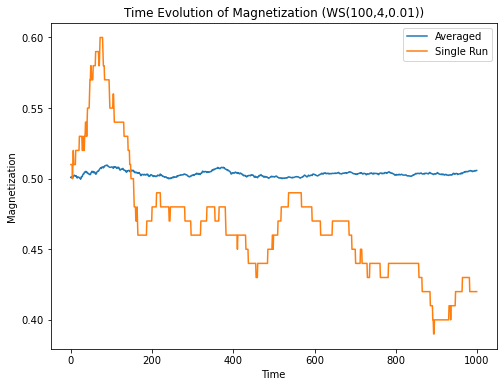

In [6]:
import matplotlib.pyplot as plt

# WS(100,4,0.01) network magnetization results
ws_network_results = magnetization_results["WS(100,4,0.01)"]

# Find the nearest available p value in the results dictionary
target_p = 0.01
available_p_values = list(ws_network_results[4].keys())
nearest_p = min(available_p_values, key=lambda x: abs(x - target_p))

# Averaged magnetization
averaged_magnetization = np.mean(ws_network_results[4][nearest_p], axis=0)

# Single run magnetization
single_run_magnetization = ws_network_results[4][nearest_p][0]

# Plotting magnetization
plt.figure(figsize=(8, 6))
plt.plot(range(1000), averaged_magnetization, label="Averaged")
plt.plot(range(1000), single_run_magnetization, label="Single Run")
plt.xlabel("Time")
plt.ylabel("Magnetization")
plt.title("Time Evolution of Magnetization (WS(100,4,0.01))")
plt.legend()
plt.show()


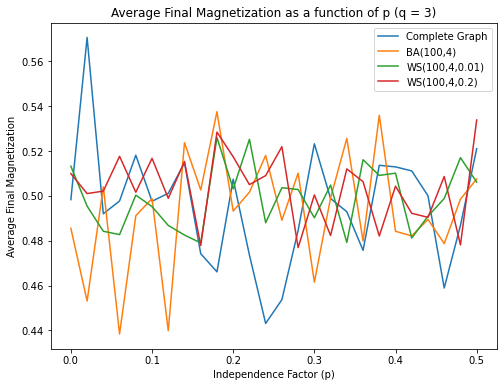

In [16]:
# Plot average final magnetization as a function of p for q = 3 and different network topologies
plt.figure(figsize=(8, 6))
for network_name, q_dict in magnetization_results.items():
    magnetization_avg_list = []
    for p, p_dict in q_dict[3].items():
        magnetization_avg = np.mean([np.mean(magnetization[-1]) for magnetization in p_dict])
        magnetization_avg_list.append(magnetization_avg)
    plt.plot(p_values, magnetization_avg_list, label=network_name)

plt.xlabel("Independence Factor (p)")
plt.ylabel("Average Final Magnetization")
plt.title("Average Final Magnetization as a function of p (q = 3)")
plt.legend()
plt.show()

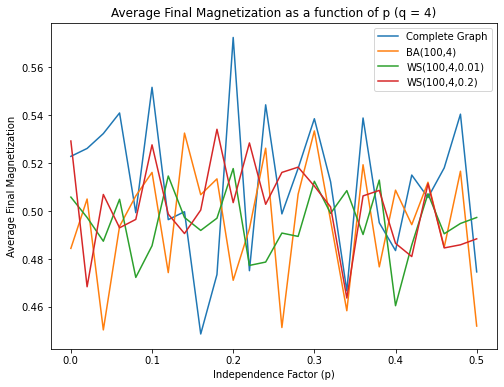

In [17]:
# Plot average final magnetization as a function of p for q = 4 and different network topologies
plt.figure(figsize=(8, 6))
for network_name, q_dict in magnetization_results.items():
    magnetization_avg_list = []
    for p, p_dict in q_dict[4].items():
        magnetization_avg = np.mean([np.mean(magnetization[-1]) for magnetization in p_dict])
        magnetization_avg_list.append(magnetization_avg)
    plt.plot(p_values, magnetization_avg_list, label=network_name)

plt.xlabel("Independence Factor (p)")
plt.ylabel("Average Final Magnetization")
plt.title("Average Final Magnetization as a function of p (q = 4)")
plt.legend()
plt.show()

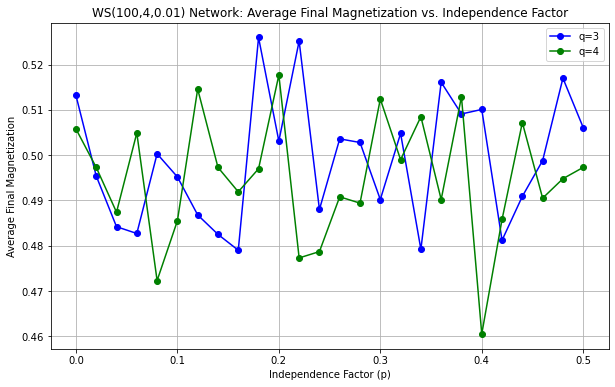

In [15]:
# Select the WS(100,4,0.01) network
network_name = "WS(100,4,0.01)"
network_data = magnetization_results[network_name]

# Set the values of q to plot
q_values_to_plot = [3, 4]

# Plot the magnetization results
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm']

for i, q in enumerate(q_values_to_plot):
    p_values_plot = []
    magnetization_avg_plot = []

    for p, magnetization_list in network_data[q].items():
        p_values_plot.append(p)
        magnetization_avg = np.mean([magnetization[-1] for magnetization in magnetization_list])
        magnetization_avg_plot.append(magnetization_avg)

    plt.plot(p_values_plot, magnetization_avg_plot, marker='o', linestyle='-', color=colors[i], label=f"q={q}")

plt.xlabel("Independence Factor (p)")
plt.ylabel("Average Final Magnetization")
plt.title(f"WS(100,4,0.01) Network: Average Final Magnetization vs. Independence Factor")
plt.legend()
plt.grid(True)
plt.show()
